# Basic MCMC Fitting Examples

In [1]:
from edges_estimate.mcmc import run_mcmc
from edges_estimate.likelihoods import GlobalSignal, Param

import numpy as np
import matplotlib.pyplot as plt

import getdist
from getdist import plots, MCSamples

%matplotlib inline

from scipy.stats import uniform, norm

import warnings

%load_ext autoreload
%autoreload 2



ImportError: cannot import name 'GlobalSignal' from 'edges_estimate.likelihoods' (/home/steven/Documents/Projects/radio/EOR/Edges/edges_estimate/edges_estimate/likelihoods.py)

In [ ]:
def residual_plot(sampler, likelihood, discard=0, thin=1):
    blobs = sampler.get_blobs(discard=discard, thin=thin, flat=True)
    for blob in blobs:
        plt.plot(likelihood.freqs, 1000*(likelihood.data - blob[0]), alpha=0.2, color='k')
    plt.xlabel("Frequency [Mhz]")
    plt.ylabel("Residual [mK]")
    plt.grid(True)

In [ ]:
def traceplot(sampler, likelihood, with_lnl=True):
    chain = sampler.get_chain()

    n = chain.shape[-1]
    if with_lnl: n += 1
        
    nn = min(int(np.sqrt(n)) + 1, n)
    mm = int(n/nn) + 1
    
    fig, ax = plt.subplots(nn,mm, sharex=True, figsize=(mm*5, nn*3), gridspec_kw={"hspace":0.05})
    
    for i, (ch, lbl) in enumerate(zip(chain.T, likelihood.parameters.values())):
        ax.flatten()[i].set_ylabel(lbl.latex, fontsize=14)
        
        for thread in ch:
            ax.flatten()[i].plot(thread, color='k', alpha=0.4)
         
    if with_lnl:
        for thread in sampler.get_log_prob().T:
            ax.flatten()[i+1].plot(thread, color='k', alpha=0.4)
            ax.flatten()[i+1].set_ylabel("Log Likelihood", fontsize=14)
        
    plt.subplots_adjust()

## Toy (Mock) Example

In [ ]:
freqs = np.linspace(60, 94, 100)

In [ ]:
likelihood = GlobalSignal(
    freqs = freqs,
    fg_model="linlog",
    params=[
        Param("A", min=0, max=1, ref=uniform(0.4, 0.2)),
        Param("tau", min=0, max=15, ref=uniform(6, 2)),
        Param("w", min=10, max=20, ref=uniform(16, 2)),
        Param("nu0", min=50, max=100, ref=uniform(70, 10)),
        Param("p0", max=5000, ref=uniform(1500, 2000)),
        Param("sigma", max=0.05, ref=norm(0.013, 0.003)),
        Param("p1", min=-1000, max=1000, prior=norm(0, 5), ref=uniform(-0.1, 0.1)), # Note: min/max on these
        Param("p2", min=-1000, max=1000, prior=norm(0, 5), ref=uniform(-0.1, 0.1)), # is primarily for the 
        Param("p3", min=-1000, max=1000, prior=norm(0, 5), ref=uniform(-0.1, 0.1)), # polychord sampler to have
        Param("p4", min=-1000, max=1000, prior=norm(0, 5), ref=uniform(-0.1, 0.1)), # a bounded support, won't affect samples.
    ],
)

In [ ]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(10, 6))
ax[0].plot(likelihood.freqs, likelihood.data)
ax[1].plot(likelihood.freqs, likelihood.data - likelihood.fg())
ax[2].plot(likelihood.freqs, likelihood.data - likelihood.model())
plt.subplots_adjust()

for x in ax:
    x.grid(True)

### EMCEE-Sampling

In [18]:
sampler = run_mcmc(
    likelihood, 
    sampler_kw = {"nwalkers":50, "threads":8},
    sampling_kw = {"nsteps":1000, "store":True, "progress":"notebook"}
)

In [19]:
samples = MCSamples(samples=sampler.get_chain(flat=False, discard=500), names = likelihood.parameters.keys(), 
                    labels = [p.latex for p in likelihood.parameters.values()])

Removed no burn in


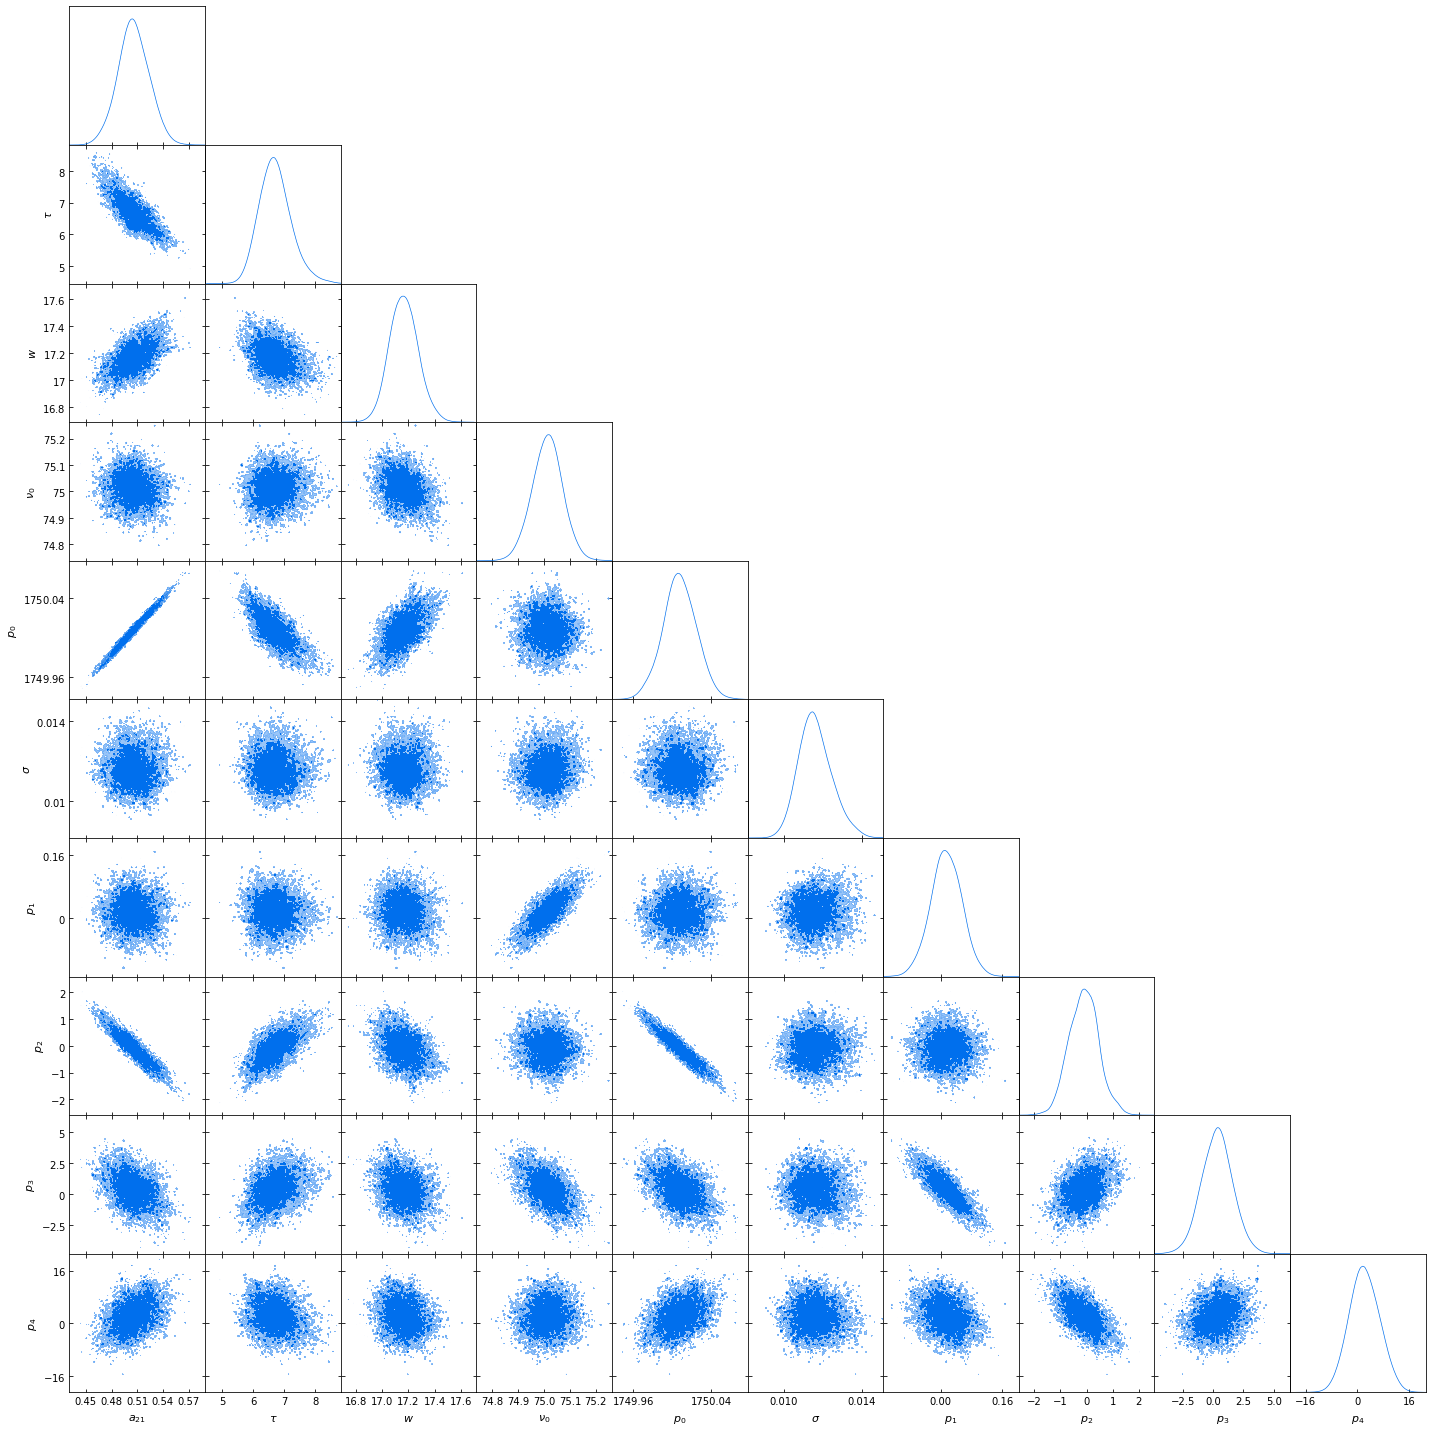

In [20]:
g = plots.getSubplotPlotter()
g.triangle_plot(
    samples, 
    param_limits={k:(samples.mean(k) - 4*samples.std(k), samples.mean(k) + 4*samples.std(k)) 
                  for k in likelihood.parameters.keys()}, 
    filled=True)

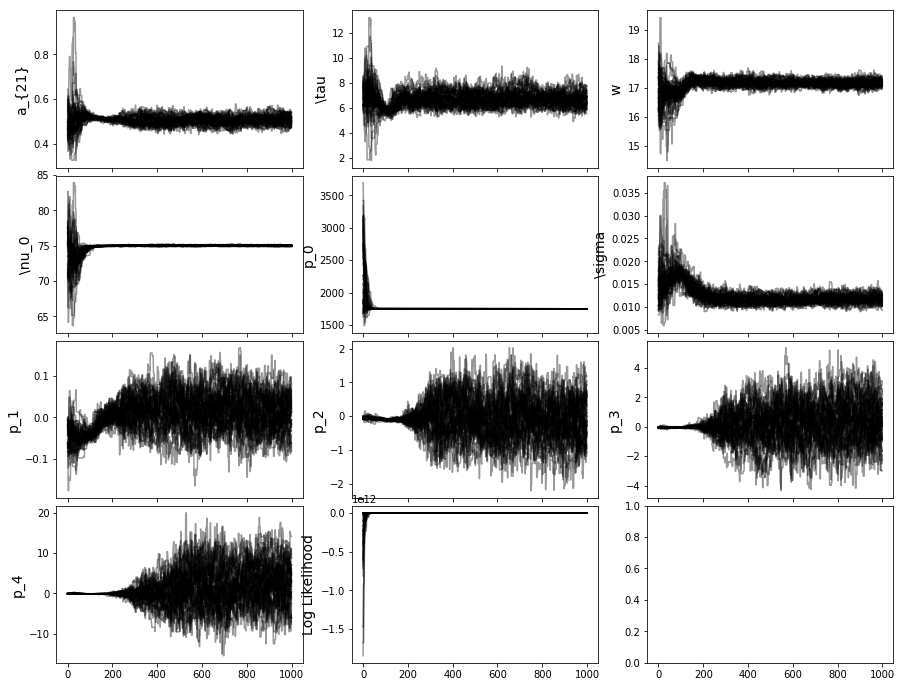

In [44]:
traceplot(sampler, likelihood)

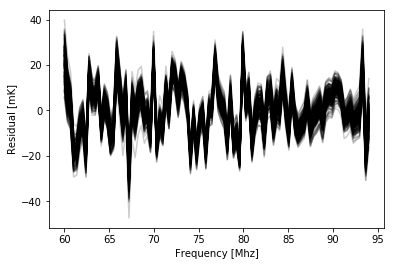

In [42]:
residual_plot(sampler, likelihood, discard=500, thin=100)

### PolyChord-based

In [12]:
sampler = run_mcmc(
    likelihood, 
    sampler='polychord',
    sampler_kw = {"read_resume":False},
#    sampling_kw = {"nsteps":1000, "store":True, "progress":"notebook"}
)

/home/steven/.local/lib/python3.7/site-packages/pypolychord-1.16-py3.7-linux-x86_64.egg/pypolychord/output.py:188: FutureWarning: read_table is deprecated, use read_csv instead.
  names= initial_col_names)


In [13]:
paramnames = [(p.name, p.latex) for p in likelihood.parameters.values()]
# also have to add derived... :-(
#paramnames += [(f'p{i}', f'p{i}') for i in range(101)]
sampler.make_paramnames_files(paramnames)



/home/steven/.local/lib/python3.7/site-packages/pypolychord-1.16-py3.7-linux-x86_64.egg/pypolychord/output.py:188: FutureWarning: read_table is deprecated, use read_csv instead.
  names= initial_col_names)


chains/test.txt
Removed no burn in


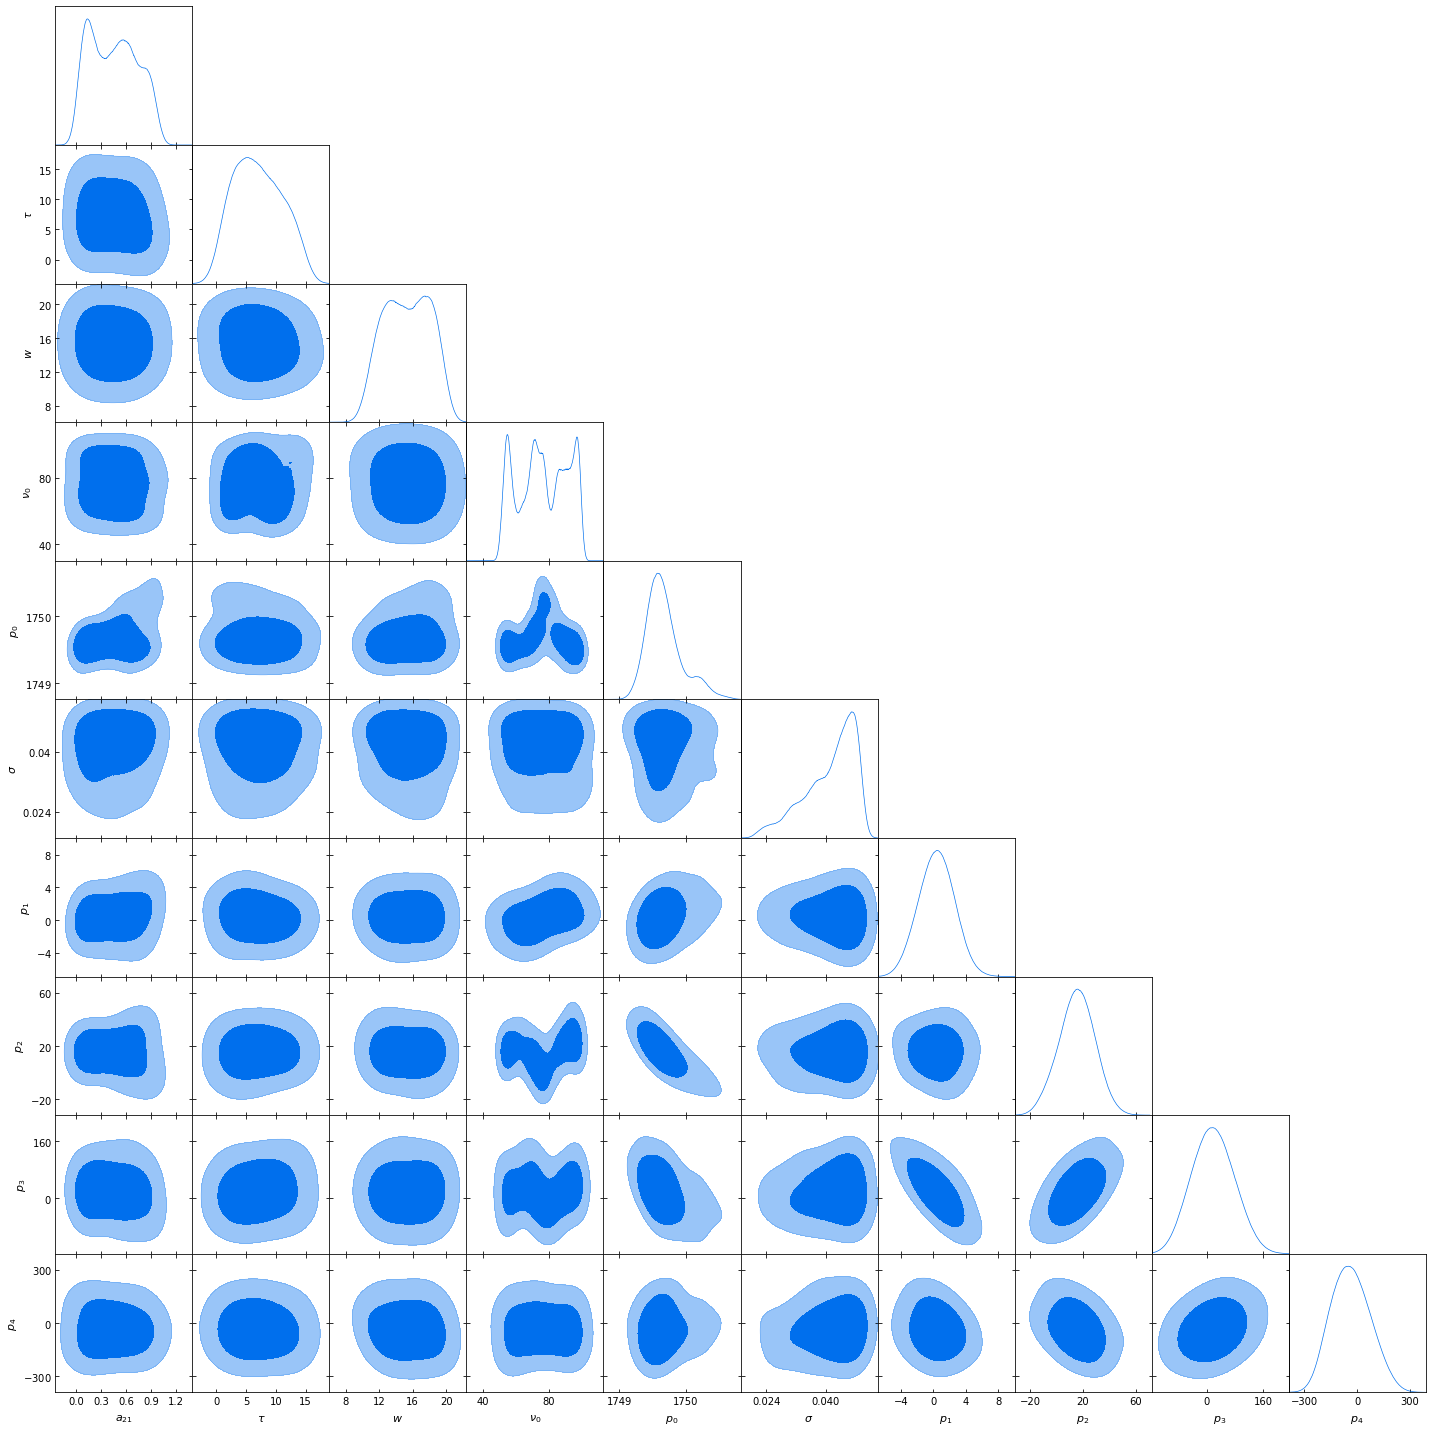

In [14]:
posterior = sampler.posterior
g = getdist.plots.getSubplotPlotter()
g.triangle_plot(posterior, filled=True)

## Try with the real data

In [4]:
data = np.genfromtxt("figure1_plotdata.csv", skip_header=1, delimiter=',')

In [5]:
freq, tsky = data[data[:,1]>0,0], data[data[:,1]>0,2]

# To follow Raul, use 60-94 MHz
tsky = tsky[np.logical_and(freq>=60, freq<=94)]
freq = freq[np.logical_and(freq>=60, freq<=94)]

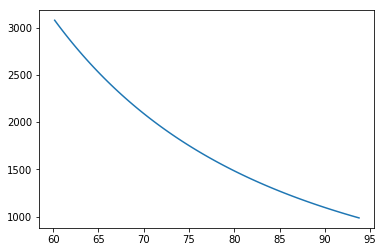

In [6]:
plt.plot(freq,tsky)

In [7]:
likelihood_rl = GlobalSignal(
    freqs = freq,
    data = tsky,
    sigma = 0.013, # Uncertainty given in Memo 111.
    fg_model="linlog",
    params=[
        Param("A", min=0, max=3, ref=uniform(0.4, 0.2)),
        #Param("tau", min=0, max=15, ref=uniform(6, 2)),
        Param("w", min=10, max=40, ref=uniform(16, 2)),
        Param("nu0", min=50, max=100, ref=uniform(70, 10)),
        Param("p0", max=5000, ref=uniform(1500, 2000)),
        Param("p1", prior=norm(0, 5), min=-1000, max=1000),
        Param("p2", prior=norm(0, 5), min=-1000, max=1000),
        Param("p3", prior=norm(0, 5), min=-1000, max=1000),
        Param("p4", prior=norm(0, 5), min=-1000, max=1000),
        Param("sigma", prior=norm(0.013, 0.01), max=0.5)
    ],
    derived=['sky_model']
)

### EMCEE-based

In [60]:
sampler2 = run_mcmc(
    likelihood_rl, 
    sampler_kw = {"nwalkers":50, "threads":8},
    sampling_kw = {"nsteps":1000, "store":True, "progress":"notebook"}
)

/home/steven/miniconda3/envs/edges/lib/python3.7/site-packages/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


In [61]:
samples = MCSamples(samples=sampler2.get_chain(flat=False, discard=500), names = likelihood.parameters.keys(), 
                    labels = [p.latex for p in likelihood.parameters.values()])

Removed no burn in


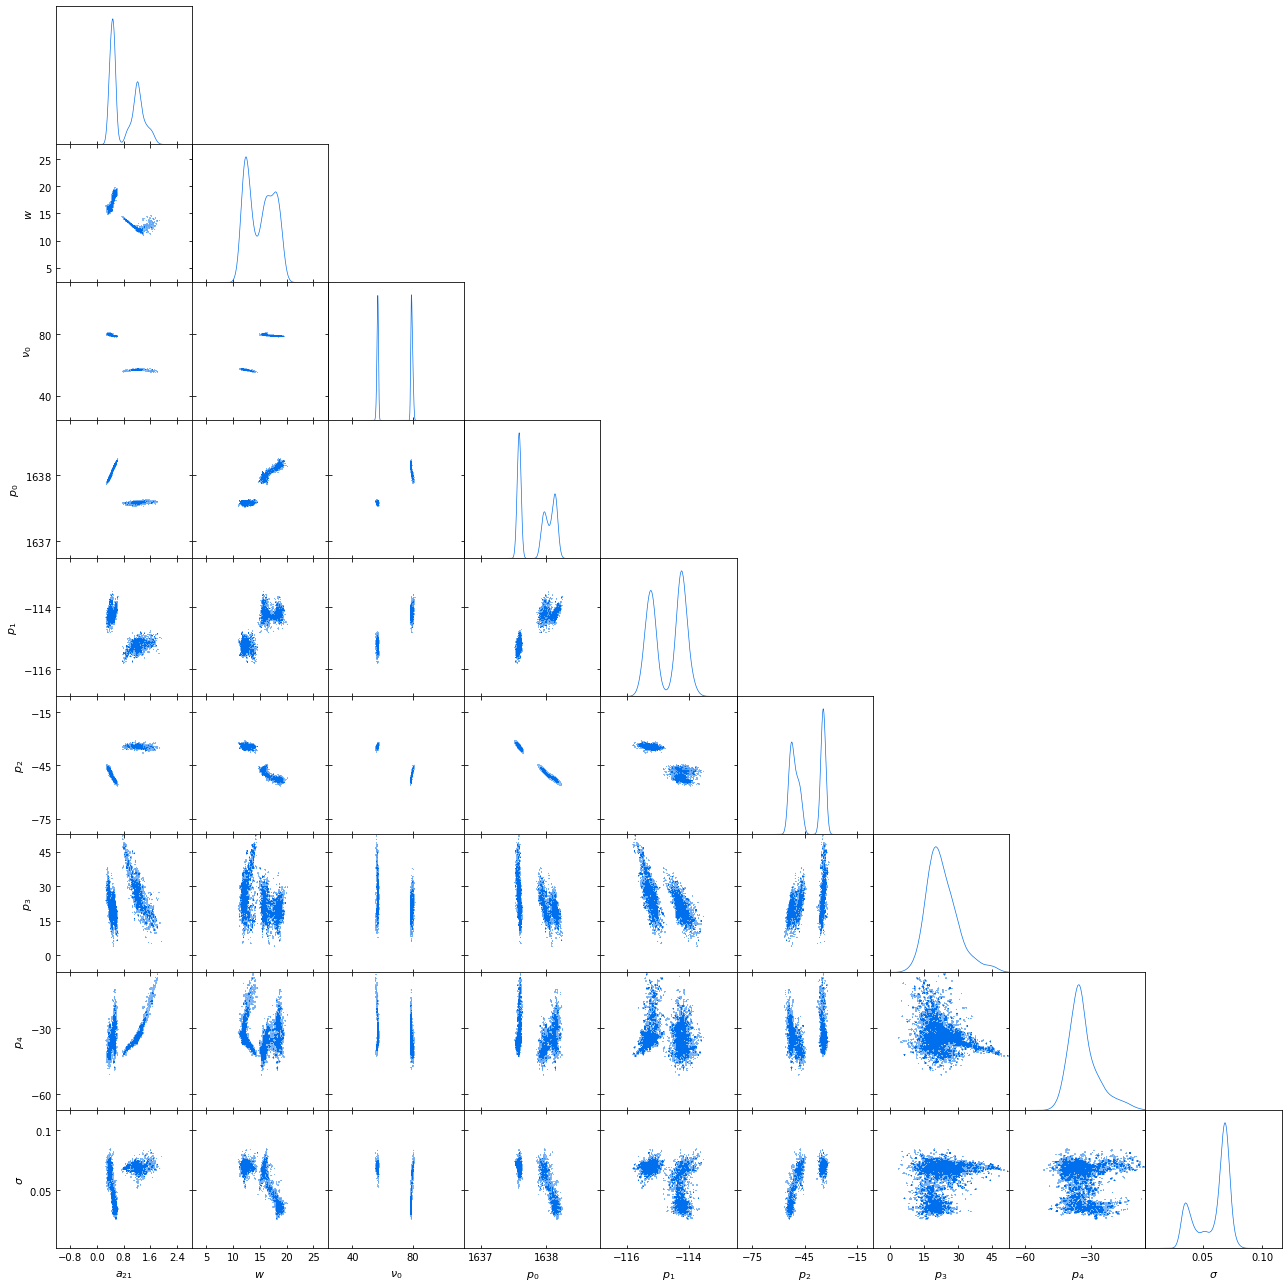

In [63]:
g = plots.getSubplotPlotter()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    g.triangle_plot(
        samples, 
        param_limits={k:(samples.mean(k) - 4*samples.std(k), samples.mean(k) + 4*samples.std(k)) 
                      for k in likelihood.parameters.keys()}, 
        filled=True)

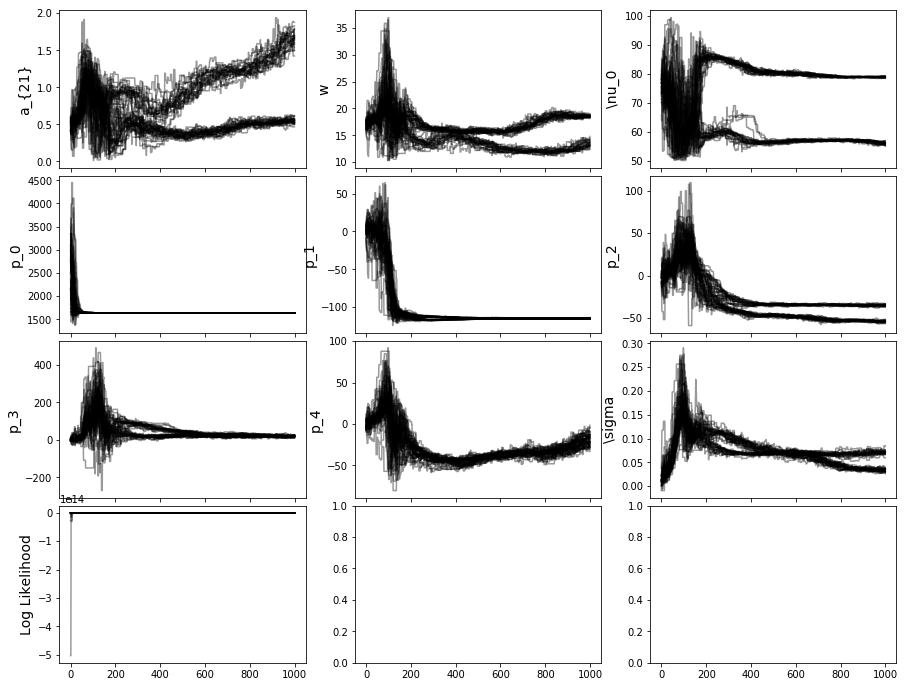

In [64]:
traceplot(sampler2, likelihood)
    

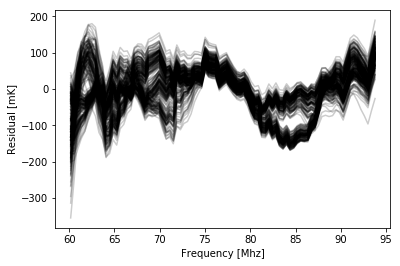

In [65]:
residual_plot(sampler2, likelihood, discard=500, thin=100)

### PolyChord

In [8]:
sampler2 = run_mcmc(
    likelihood_rl, 
    sampler='polychord',
    sampler_kw = {"read_resume":True, "base_dir":'real_test'},
)

/home/steven/.local/lib/python3.7/site-packages/pypolychord-1.16-py3.7-linux-x86_64.egg/pypolychord/output.py:188: FutureWarning: read_table is deprecated, use read_csv instead.
  names= initial_col_names)


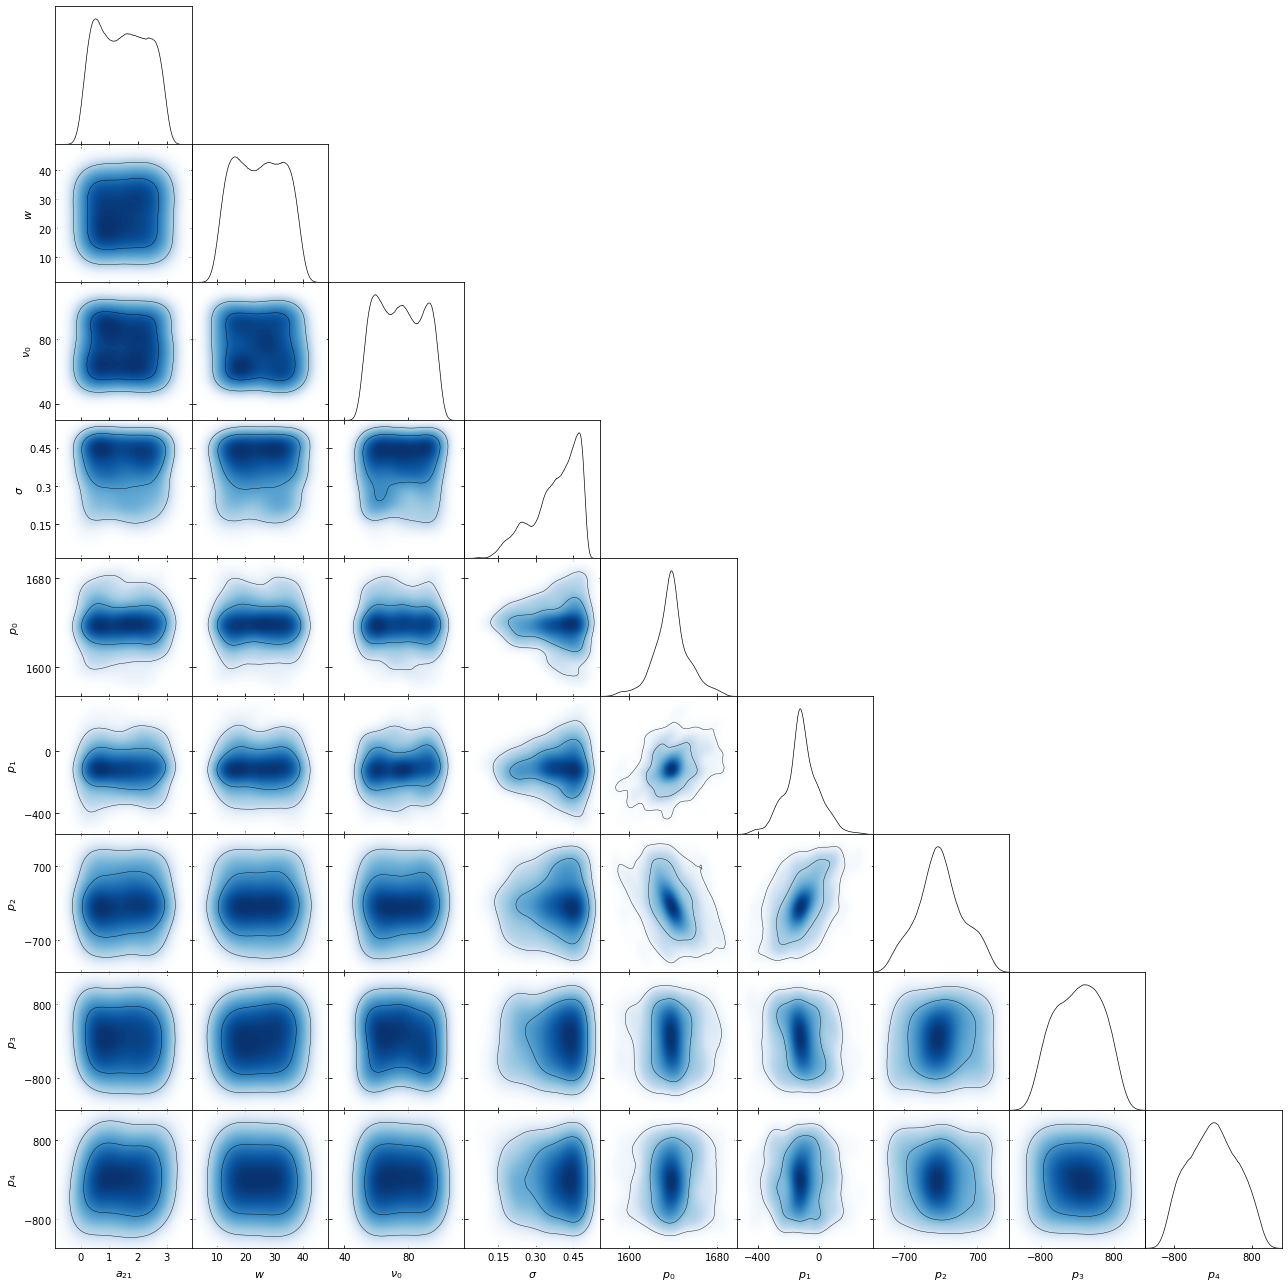

In [13]:
posterior = sampler2.posterior
g = getdist.plots.getSubplotPlotter()
g.triangle_plot(posterior, params=['A', 'w', 'nu0', 'sigma', 'p0', 'p1', 'p2', 'p3', 'p4'], shaded=True)